***Participantes (RM - NOME):***<br>
348112 - Kaio<br>
348012 - Evandro<br>
343832 - Pedro Emil<br>
348196 - Julia<br>

# Introdução e Setup

A QuantumFinance está desejando construir um fundo de ações baseado em
modelos de Deep Learning. A ideia é desenvolver um modelo que tenha como
saída a compra ou venda de um determinada ação baseado na movimentação
do mercado nos últimos 15 dias.
Inicialmente 4 ações foram selecionadas para análise:

- VALE3 – Vale do Rio Doce
- PETR4 – Petrobras
- BBAS3 – Banco do Brasil
- CSNA3 - Companhia Siderúrgica Nacional

| Date | Close | Smoothed_Close | Label | D-1 ~ D-15 |
|--|--|--|--|--|
| Data da Operação | Valor de Fechamento do dia | Close trabalhado | -1 Venda, 1 Compra | Close Dias anteriores |

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, BatchNormalization, Dropout, Dense, Conv1D, Flatten, MaxPooling1D, Bidirectional
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
import gc

In [ ]:
def prepare_network_analysis_dataframe(df):
    """
    Prepara um DataFrame para análise de rede, adicionando médias móveis, variações de preços, Bandas de Bollinger e indicadores MACD.

    A função modifica o DataFrame de entrada adicionando novas colunas que incluem:
    - Médias móveis para janelas de 5, 10 e 15 dias.
    - Variação do preço de fechamento para os últimos 5, 10 e 15 dias.
    - Bandas de Bollinger para uma janela de 15 dias.
    - Linha MACD, linha de sinal MACD e histograma MACD.

    Parâmetros:
    - df (DataFrame): DataFrame de entrada contendo dados do mercado financeiro. Deve incluir as colunas 'Label', 'Close' e 'Past_X_Days_Close', onde X pode ser 5, 10, 15, etc.

    Retorna:
    - DataFrame: um novo DataFrame com as colunas adicionais necessárias para análise de rede.

    Nota: A coluna 'Label' é binarizada, substituindo -1 por 0. Os cálculos das Bandas de Bollinger e MACD são baseados na coluna 'Close'.
    """
    new_df = df[["Label", "Close"]].copy()
    new_df["Label"] = new_df["Label"].replace({-1:0})


    for window in [5, 10, 15]:
        ma_col = f"ma_{window}"
        new_df[ma_col] = df.iloc[:, 5:(5 + window)].mean(axis=1) #Medias Moveis
        new_df[f"D{window}"] = df["Close"] - df[f"Past_{window}_Days_Close"] #Variação da Close
        if window == 15:
            std = df.iloc[:, 5:(5 + window)].std(axis=1)
            new_df["BB_upper_15"] = new_df[ma_col] + (2 * std)
            new_df["BB_lower_15"] = new_df[ma_col] - (2 * std)
            new_df["bb_center_15"] = (new_df["Close"] - new_df["BB_lower_15"]) / (new_df["BB_upper_15"] - new_df["BB_lower_15"])
            new_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Substitui Inf por NaN
            new_df["bb_center_15"].fillna(0, inplace=True)  # Preenche NaNs com 0

    #MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_histogram = macd_line - signal_line

    new_df["MACD_line"] = macd_line
    new_df["MACD_SignalL"] = signal_line
    new_df["MACD_Hist"] = macd_histogram

    return new_df
    pass

In [ ]:
def make_timesteps_sequences(df, time_steps):
    """
    Transforma um DataFrame em sequências de passos temporais para uso em modelos de aprendizado de máquina, especialmente para problemas de séries temporais.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados de série temporal.
    - time_steps (int): Número de passos temporais a serem incluídos em cada sequência.

    Retorna:
    - X (ndarray): Array de sequências de características com a forma [n_amostras, time_steps, n_características].
    - y (ndarray): Array de rótulos com a forma [n_amostras,], correspondendo a cada sequência em X.

    Nota: A normalização é aplicada apenas às características, não aos rótulos. 'Label' é assumido como a coluna alvo para previsão.
    """
    selected_features = df.drop(["Label", "BB_upper_15", "BB_lower_15"], axis=1)
    scaler = MinMaxScaler()
    scaler.fit(selected_features)
    scaled_data = scaler.transform(selected_features)


    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        sequence = scaled_data[i:i + time_steps]  # Select sequence of time steps
        label = df['Label'].iloc[i + time_steps]  # Assuming 'Label' is what you're predicting
        X.append(sequence)
        y.append(label)

    X = np.array(X)  # Shape: [samples, time_steps, features]
    y = np.array(y)  # Shape: [samples,]
    print(f"X.shape:{X.shape}, y.shape:{y.shape}")
    return X, y

In [ ]:
def linear_split(X, y, split_percent):
    """
    Divide os arrays X e y em conjuntos de treinamento e teste com base em uma porcentagem especificada.

    A função calcula o índice de divisão com base na porcentagem fornecida e divide os dados de entrada e rótulos correspondentes
    em conjuntos de treinamento e teste. A divisão é feita de forma linear, mantendo a ordem original dos dados.

    Parâmetros:
    - X (ndarray): Array de dados de entrada com a forma [n_amostras, n_características].
    - y (ndarray): Array de rótulos com a forma [n_amostras,].
    - split_percent (float): A porcentagem dos dados a serem usados para o conjunto de treinamento. Deve ser um valor entre 0 e 1.

    Retorna:
    - X_train (ndarray): Array de dados de treinamento.
    - y_train (ndarray): Array de rótulos de treinamento.
    - X_test (ndarray): Array de dados de teste.
    - y_test (ndarray): Array de rótulos de teste.

    Nota: A divisão é realizada com base na ordem original dos dados, sem embaralhamento.
    """
    split_index = int(len(X) * split_percent)
    X_train = X[:split_index]
    X_test =  X[split_index:]

    y_train = y[:split_index]
    y_test =  y[split_index:]

    return X_train, y_train, X_test, y_test

In [ ]:
def create_model(layers_config):
    """
    Constrói um modelo de rede neural baseado em uma configuração de camadas fornecida.

    Esta função inicializa um modelo Sequencial e adiciona dinamicamente camadas a ele com base nas
    especificações contidas na lista `layers_config`. Cada item nesta lista é um dicionário
    especificando o tipo de camada e seus parâmetros, como número de unidades, função de ativação,
    tamanho do kernel, etc. Os tipos de camadas suportados incluem densa, bidirecional (com LSTM como a
    camada interna), LSTM, convolucional (Conv1D), dropout, achatamento (Flatten), normalização em lote (BatchNormalization)
    e pooling máximo (MaxPooling1D).

    Parâmetros:
    - layers_config (lista de dict): Uma lista onde cada elemento é um dicionário detalhando a configuração
      de uma camada para adicionar ao modelo. As chaves no dicionário podem incluir 'type' (obrigatório) para especificar o
      tipo de camada, e também podem incluir 'units', 'activation', 'kernel_size', 'return_sequences', 'rate',
      e 'pool_size', dependendo do tipo de camada.

    Retorna:
    - Sequential: Um modelo Sequencial do Keras compilado com o otimizador Adam, usando o erro quadrático médio como a
      função de perda e rastreando o erro quadrático médio como métrica.

    Exemplo:
    ```
    layers_config = [
        {'type': 'dense', 'units': 64, 'activation': 'relu'},
        {'type': 'lstm', 'units': 128, 'activation': 'tanh', 'return_sequences': True},
        {'type': 'dropout', 'rate': 0.2},
        {'type': 'flatten'},
        {'type': 'dense', 'units': 1, 'activation': 'sigmoid'}
    ]
    model = create_model(layers_config)
    ```

    Nota:
    - A forma de entrada para a primeira camada deve ser pré-definida como (time_steps, FEATURES) fora desta função.
    - A camada final é uma camada densa com uma única unidade e função de ativação sigmoid, tornando esta
      função particularmente adequada para tarefas de classificação binária.
    """
    _model = Sequential()
    # Camada de Entrada
    _model.add(InputLayer(input_shape=(time_steps, FEATURES)))
    #Normalização
    _model.add(BatchNormalization())

    #Outras camadas
    for i, layer in enumerate(layers_config):
        layer_type = layer.get("type", "dense")
        units = layer.get("units", 64)
        activation = layer.get("activation", "relu")
        kernel_size = layer.get("kernel_size", 5)
        return_sequences = layer.get("return_sequences", False)
        rate = layer.get("rate", 0.2)
        pool_size = layer.get("pool_size", 2)

        if layer_type == "dense":
            _model.add(Dense(units, activation=activation))

        elif layer_type == "bidirectional":
            layer = layer.get("layer", None)
            layer_type = layer.get("type", "dense")
            units = layer.get("units", 64)
            activation = layer.get("activation", "relu")
            kernel_size = layer.get("kernel_size", 5)
            return_sequences = layer.get("return_sequences", False)
            rate = layer.get("rate", 0.2)
            pool_size = layer.get("pool_size", 2)

            if layer_type == "lstm":
                if i == 0:
                    internal = LSTM(units, activation=activation, return_sequences=return_sequences, input_shape=(time_steps, FEATURES))
                else:
                    internal = LSTM(units, activation=activation, return_sequences=return_sequences)

            _model.add(Bidirectional(internal))

        elif layer_type == "lstm":
            if i == 0:
                _model.add(LSTM(units, activation=activation, return_sequences=return_sequences, input_shape=(time_steps, FEATURES)))
            else:
                _model.add(LSTM(units, activation=activation, return_sequences=return_sequences))

        elif layer_type == "conv1d":
            _model.add(Conv1D(units, kernel_size=kernel_size, activation=activation))

        elif layer_type == "dropout":
            _model.add(Dropout(rate))

        elif layer_type == "flatten":
            _model.add(Flatten())

        elif layer_type == "batch_normalization":
            _model.add(BatchNormalization())

        elif layer_type == "max_pooling1d":
            _model.add(MaxPooling1D(pool_size=pool_size))



    #Camada de saida
    _model.add(Dense(1, activation="sigmoid"))


    _model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    return _model

In [ ]:
def create_and_train(dataset, time_steps=15, model={}, epochs=16, batch_size=16):
    """
    Cria e treina um modelo de rede neural com base na configuração fornecida e no conjunto de dados.

    Esta função inicializa um modelo de rede neural usando a função `create_model`, compila o modelo com
    o otimizador Adam e a função de perda de erro quadrático médio (MSE), e então treina o modelo
    usando os dados fornecidos. Após o treinamento, a função avalia o modelo no conjunto de teste
    e imprime as métricas de acurácia, precisão, recall e F1.

    Parâmetros:
    - dataset (array): O conjunto de dados a ser usado para treinamento e teste do modelo.
    - time_steps (int, opcional): O número de etapas de tempo a serem consideradas para cada amostra de entrada.
    - model (dict, opcional): Um dicionário contendo a configuração das camadas do modelo a ser criado.
    - epochs (int, opcional): O número de épocas para o treinamento do modelo.
    - batch_size (int, opcional): O tamanho do lote a ser usado durante o treinamento do modelo.

    Retorna:
    - Sequential: O modelo treinado.

    Exemplo de uso:
    ```python
    dataset = np.random.rand(1000, 10)  # Exemplo de dataset
    model_config = [
        {'type': 'lstm', 'units': 64, 'return_sequences': True},
        {'type': 'dropout', 'rate': 0.2},
        {'type': 'lstm', 'units': 32},
        {'type': 'dense', 'units': 1, 'activation': 'sigmoid'}
    ]
    trained_model = create_and_train(dataset, time_steps=15, model=model_config, epochs=10, batch_size=16)
    ```

    Nota:
    - A função assume que o `dataset` é uma matriz NumPy onde a última coluna é o alvo e as demais são características.
    - A função `make_timesteps_sequences` é usada para transformar o conjunto de dados em sequências de acordo com `time_steps`.
    - A função `linear_split` é usada para dividir o conjunto de dados transformado em conjuntos de treinamento e teste.
    - As métricas de acurácia, precisão, recall e F1 são calculadas no conjunto de teste e impressas ao final do treinamento.
    """

    _model = create_model(model)

    _model.compile(optimizer='adam',
               loss='mean_squared_error',  # MSE for regression
               metrics=['mse'])  # MSE metric for regression

    X, y = make_timesteps_sequences(dataset, time_steps)
    X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)
    history = _model.fit(
        X_train, y_train,
        epochs=epochs,  # Number of epochs
        batch_size=batch_size,  # Size of the batch
        validation_split=0.2  # Split for validation data
    )

    predictions = _model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print(f'Acurácia: {accuracy}, Precisão: {precision}, Recall: {recall}, F1: {f1}')
    return _model

In [ ]:
def plot_best_scores(best_scores):
    """
    Exibe um gráfico de barras dos melhores escores para uma série de redes.

    Esta função cria um gráfico de barras que mostra os melhores escores alcançados por diferentes configurações de rede.
    Assume-se que a lista `best_scores` contenha os escores máximos obtidos por cada configuração de rede, e que
    existam 10 configurações de rede numeradas de 0 a 9.

    Parâmetros:
    - best_scores (list): Uma lista contendo os melhores escores obtidos por cada configuração de rede.

    Exemplo de uso:
    ```python
    best_scores = [0.8, 0.85, 0.78, 0.9, 0.95, 0.88, 0.82, 0.87, 0.92, 0.89]
    plot_best_scores(best_scores)
    ```

    Nota:
    - A função utiliza a biblioteca matplotlib para criar e exibir o gráfico de barras.
    - As redes são numeradas de 0 a 9, e cada barra no gráfico corresponde a um desses números, representando
      diferentes configurações de rede.
    - O eixo Y do gráfico mostra os melhores escores, enquanto o eixo X representa as diferentes redes.
    """
    networks = range(10)
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(networks, best_scores, color='skyblue')
    plt.title('Best Scores')
    plt.xlabel('Network')
    plt.ylabel('Best Score')
    plt.xticks(networks)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()


In [ ]:
def multi_network_grid_search(dataset, networks):
    """
    Realiza uma busca em grade (Grid Search) para várias configurações de redes neurais em uma série temporal.

    Esta função itera sobre várias configurações de redes neurais fornecidas e realiza uma busca em grade para encontrar
    os melhores parâmetros de treinamento (como número de épocas e tamanho do lote) com base na pontuação F1.
    Utiliza validação cruzada específica para séries temporais para garantir a validade dos resultados de treinamento.

    Parâmetros:
    - dataset (DataFrame): Um pandas DataFrame contendo os dados da série temporal para treinamento.
    - networks (list): Uma lista de dicionários, onde cada dicionário contém a configuração de uma rede neural a ser testada.

    Retornos:
    - Esta função não retorna um valor específico. Ela imprime os melhores parâmetros e a melhor pontuação F1 para cada
      configuração de rede testada e plota os melhores escores usando a função `plot_best_scores`.

    Notas:
    - A função assume que cada configuração de rede na lista `networks` é válida e compatível com a função `create_model`.
    - `FEATURES` e `time_steps` são fixados dentro da função, mas podem ser ajustados conforme necessário.
    - A busca em grade é realizada usando `GridSearchCV` do scikit-learn com validação cruzada para séries temporais (`TimeSeriesSplit`).
    - A função utiliza o `KerasClassifier` para integrar modelos do Keras com a interface de busca em grade do scikit-learn.

    Exemplo de uso:
    ```python
    dataset = pd.read_csv('meu_dataset.csv')
    networks = [
        {"layers": [{"type": "lstm", "units": 64}, {"type": "dense", "units": 1, "activation": "sigmoid"}]},
        {"layers": [{"type": "lstm", "units": 128}, {"type": "dense", "units": 1, "activation": "sigmoid"}]}
    ]
    multi_network_grid_search(dataset, networks)
    ```
    """
    FEATURES = 11
    time_steps=15
    X, y = make_timesteps_sequences(dataset, time_steps)

    best_score = []
    best_parameters = []
    for i, network in enumerate(networks):
        print(f"〉〉〉Starting Grid Search Network {i}")
        kmodel = KerasClassifier(model=lambda: create_model(network), shuffle=False, verbose=0)
        param_grid = {"epochs":[64, 128], "batch_size":[16, 32]}
        tscv = TimeSeriesSplit(n_splits=2)
        scorer = make_scorer(f1_score)

        grid = GridSearchCV(estimator=kmodel, param_grid=param_grid, cv=tscv, scoring=scorer, error_score=-1, verbose=3)
        grid_res = grid.fit(X, y)
        print("Best Parameters:", grid_res.best_params_)
        print("Best Score:", grid_res.best_score_)
        best_score.append(grid_res.best_score_)
        best_parameters.append(grid_res.best_params_)
        print(f"〉〉〉Ending Grid Search Newtok {i}")

    for i in range(10):
        print(f"Network: {i}, \t best score:{best_score[i]}, \t best parameters:{best_parameters[i]}")
    plot_best_scores(best_score)
    gc.collect()

In [ ]:
network_0_config = [
    {"type": "dense", "units": 64, "activation": "relu"},
    {"type": "dropout", "rate": 0.2},
    {"type": "dense", "units": 64, "activation": "relu"},
    {"type": "dropout", "rate": 0.2},
    {"type": "flatten"}
]
network_1_config = [
    {"type": "conv1d", "units": 64, "kernel_size": 5, "activation": "relu"},
    {"type": "dropout", "rate": 0.5},
    {"type": "conv1d", "units": 32, "kernel_size": 3, "activation": "relu"},
    {"type": "dropout", "rate": 0.5},
    {"type": "flatten"}
]
network_2_config = [
    {"type": "lstm", "units": 64, "activation": "relu"}
]
network_3_config = [
    {"type": "lstm", "units": 64, "activation": "tanh", "return_sequences": True},
    {"type": "batch_normalization"},
    {"type": "lstm", "units": 32, "activation": "tanh"},
    {"type": "batch_normalization"},
    {"type": "dropout", "rate": 0.2},
    {"type": "dense", "units": 64, "activation": "relu"},
    {"type": "batch_normalization"},
    {"type": "dropout", "rate": 0.2},
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "batch_normalization"}
]
network_4_config = [
    {"type": "lstm", "units": 32, "activation": "tanh", "return_sequences": True},
    {"type": "dropout", "rate": 0.3},
    {"type": "lstm", "units": 16, "activation": "tanh"},
    {"type": "dropout", "rate": 0.3},
    {"type": "dense", "units": 16, "activation": "relu"},
    {"type": "batch_normalization"}
]
network_5_config = [
    {"type": "conv1d", "units": 32, "kernel_size": 3, "activation": "relu"},
    {"type": "max_pooling1d", "pool_size": 2},
    {"type": "conv1d", "units": 64, "kernel_size": 3, "activation": "relu"},
    {"type": "max_pooling1d", "pool_size": 2},
    {"type": "flatten"},
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "dropout", "rate": 0.4}
]
network_6_config = [
    {"type": "lstm", "units": 50, "activation": "relu", "return_sequences": True},
    {"type": "lstm", "units": 25, "activation": "relu"},
    {"type": "dense", "units": 25, "activation": "relu"},
    {"type": "dropout", "rate": 0.2}
]
network_7_config = [
    {"type": "bidirectional", "layer": {"type": "lstm", "units": 64, "activation": "tanh"}},
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "dropout", "rate": 0.25}
]
network_8_config = [
    {"type": "conv1d", "units": 32, "kernel_size": 3, "activation": "relu"},
    {"type": "max_pooling1d", "pool_size": 2},
    {"type": "lstm", "units": 32, "activation": "tanh"},
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "dropout", "rate": 0.3}
]
network_9_config = [
    {"type": "flatten"},
    {"type": "dense", "units": 128, "activation": "relu"},
    {"type": "batch_normalization"},
    {"type": "dense", "units": 64, "activation": "relu"},
    {"type": "batch_normalization"},
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "dropout", "rate": 0.3}
]

networks = [network_1_config, network_2_config, network_3_config, network_4_config, network_5_config, network_6_config, network_7_config, network_8_config, network_9_config, network_10_config]

# BBAS

In [ ]:
bbas_df = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/BBAS3.SA/treino.csv")
bbas_p = prepare_network_analysis_dataframe(bbas_df)

X.shape:(85, 15, 11), y.shape:(85,)
〉〉〉Starting Grid Search Network 0
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Creating model: densedropoutdensedropoutflatten[CV 1/2] END ..........batch_size=16, epochs=64;, score=0.000 total time=   1.8s
Creating model: densedropoutdensedropoutflatten

[CV 2/2] END ..........batch_size=16, epochs=64;, score=0.345 total time=   2.6s
Creating model: densedropoutdensedropoutflatten

[CV 1/2] END .........batch_size=16, epochs=128;, score=0.000 total time=   2.6s
Creating model: densedropoutdensedropoutflatten[CV 2/2] END .........batch_size=16, epochs=128;, score=0.286 total time=   3.0s
Creating model: densedropoutdensedropoutflatten[CV 1/2] END ..........batch_size=32, epochs=64;, score=0.182 total time=   2.6s
Creating model: densedropoutdensedropoutflatten[CV 2/2] END ..........batch_size=32, epochs=64;, score=0.923 total time=   1.9s
Creating model: densedropoutdensedropoutflatten[CV 1/2] END .........batch_size=32, epochs=128;, score=0.462 total time=   2.6s
Creating model: densedropoutdensedropoutflatten[CV 2/2] END .........batch_size=32, epochs=128;, score=0.923 total time=  48.6s
Creating model: densedropoutdensedropoutflattenBest Parameters: {'batch_size': 32, 'epochs': 128}
Best Score: 0.6923076923076923
〉〉〉Ending Grid Search Newtok 0
〉〉〉Starting Grid Search Network 1
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Creating model: conv1ddrop

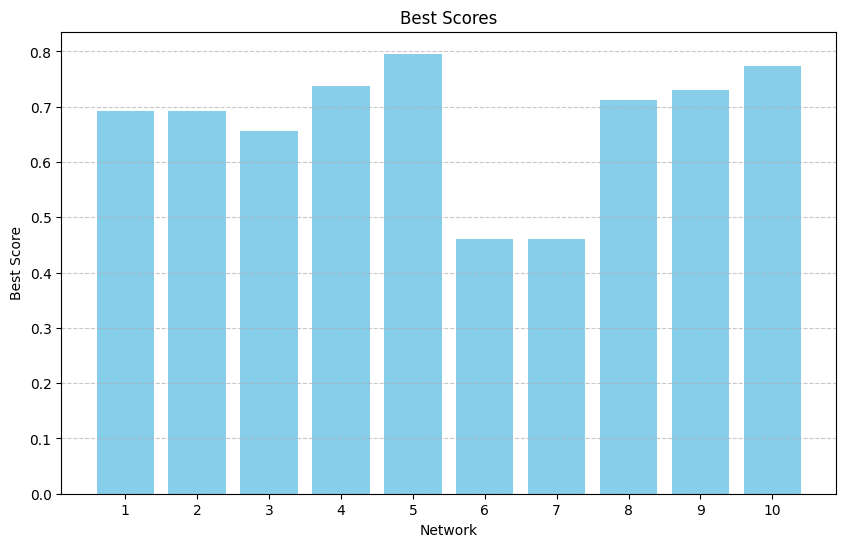

In [ ]:
multi_network_grid_search(bbas_p[1000:1100], networks)

X.shape:(4720, 15, 11), y.shape:(4720,)
Epoch 1/128
95/95 [==============================] - 7s 27ms/step - loss: 0.1837 - mse: 0.1837 - val_loss: 0.2399 - val_mse: 0.2399
Epoch 2/128
95/95 [==============================] - 2s 22ms/step - loss: 0.1380 - mse: 0.1380 - val_loss: 0.2056 - val_mse: 0.2056
Epoch 3/128
95/95 [==============================] - 2s 19ms/step - loss: 0.1195 - mse: 0.1195 - val_loss: 0.1445 - val_mse: 0.1445
Epoch 4/128
95/95 [==============================] - 1s 15ms/step - loss: 0.1070 - mse: 0.1070 - val_loss: 0.0966 - val_mse: 0.0966
Epoch 5/128
95/95 [==============================] - 1s 15ms/step - loss: 0.0955 - mse: 0.0955 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 6/128
95/95 [==============================] - 1s 15ms/step - loss: 0.0942 - mse: 0.0942 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 7/128
95/95 [==============================] - 1s 15ms/step - loss: 0.0848 - mse: 0.0848 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 8/128
95/95 [=================

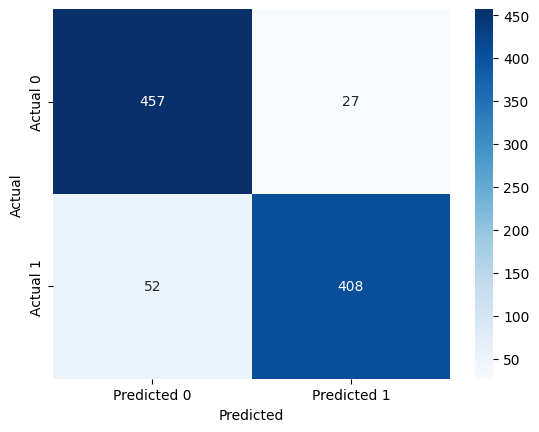

Acurácia: 0.9163135593220338, Precisão: 0.9379310344827586, Recall: 0.8869565217391304, F1: 0.911731843575419


In [ ]:
modelo_bbas = create_and_train(bbas_p, model=networks[4], batch_size=32, epochs=128)

X.shape:(1170, 15, 11), y.shape:(1170,)
37/37 [==============================] - 0s 8ms/step


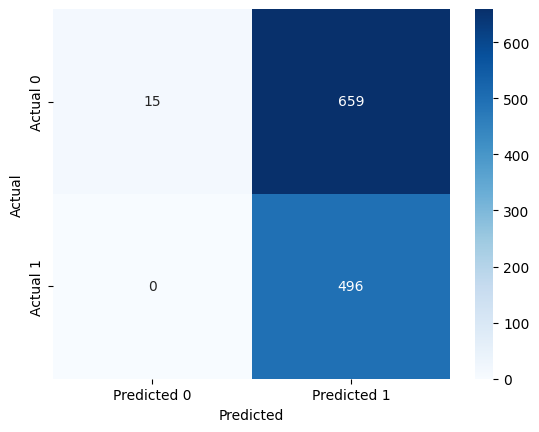

Acurácia: 0.43675213675213675, Precisão: 0.42943722943722945, Recall: 1.0, F1: 0.600847970926711


In [ ]:
bbas_df_t = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/BBAS3.SA/teste.csv")
validate_model(bbas_df_t, modelo_bba, 15)

# VALE

In [ ]:
vale_df = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/VALE3.SA/treino.csv")
vale_p = prepare_network_analysis_dataframe(vale_df)

X.shape:(85, 15, 11), y.shape:(85,)
〉〉〉Starting Grid Search Network 0
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ..........batch_size=16, epochs=64;, score=0.333 total time=   5.0s
[CV 2/2] END ..........batch_size=16, epochs=64;, score=0.667 total time=   4.8s
[CV 1/2] END .........batch_size=16, epochs=128;, score=0.667 total time=   3.6s
[CV 2/2] END .........batch_size=16, epochs=128;, score=0.667 total time=   4.3s
[CV 1/2] END ..........batch_size=32, epochs=64;, score=0.400 total time=   2.0s
[CV 2/2] END ..........batch_size=32, epochs=64;, score=0.000 total time=   2.1s
[CV 1/2] END .........batch_size=32, epochs=128;, score=0.400 total time=   2.6s
[CV 2/2] END .........batch_size=32, epochs=128;, score=0.667 total time=   4.3s
Best Parameters: {'batch_size': 16, 'epochs': 128}
Best Score: 0.6666666666666665
〉〉〉Ending Grid Search Newtok 0
〉〉〉Starting Grid Search Network 1
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ....

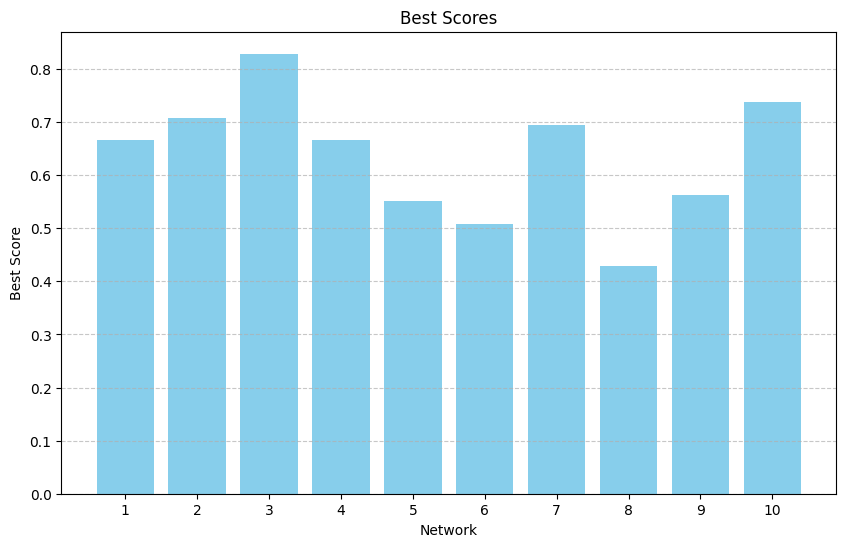

In [ ]:
multi_network_grid_search(vale_p[1000:1100], networks)

X.shape:(4793, 15, 11), y.shape:(4793,)
Epoch 1/128
192/192 [==============================] - 4s 12ms/step - loss: 0.1361 - mse: 0.1361 - val_loss: 0.2274 - val_mse: 0.2274
Epoch 2/128
192/192 [==============================] - 3s 15ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 3/128
192/192 [==============================] - 3s 13ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 4/128
192/192 [==============================] - 2s 11ms/step - loss: 0.0835 - mse: 0.0835 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 5/128
192/192 [==============================] - 2s 11ms/step - loss: 0.0784 - mse: 0.0784 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 6/128
192/192 [==============================] - 2s 11ms/step - loss: 0.0774 - mse: 0.0774 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 7/128
192/192 [==============================] - 2s 11ms/step - loss: 0.0785 - mse: 0.0785 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 8/128
192/192 [=

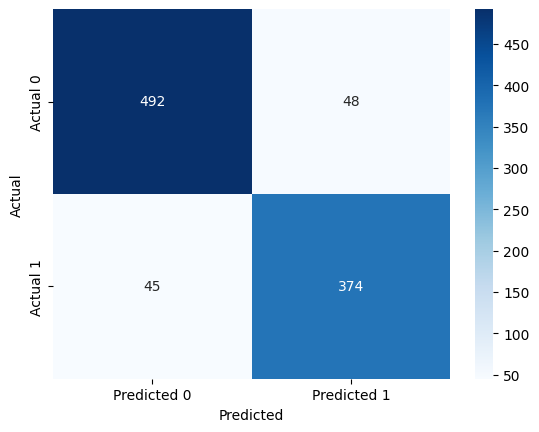

Acurácia: 0.9030239833159541, Precisão: 0.8862559241706162, Recall: 0.8926014319809069, F1: 0.8894173602853745


In [ ]:
modelo_vale = create_and_train(vale_p, model=networks[2], batch_size=16, epochs=128)

X.shape:(1188, 15, 11), y.shape:(1188,)
38/38 [==============================] - 0s 4ms/step


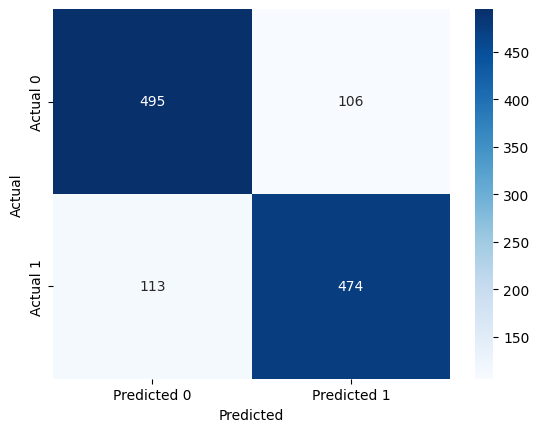

Acurácia: 0.8156565656565656, Precisão: 0.8172413793103448, Recall: 0.807495741056218, F1: 0.8123393316195373


In [ ]:
vale_df_t = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/VALE3.SA/teste.csv")
validate_model(vale_df_t, modelo_vale, 15)

# CSNA

In [ ]:
csna_df = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/CSNA3.SA/treino.csv")
csna_p = prepare_network_analysis_dataframe(csna_df)

X.shape:(85, 15, 11), y.shape:(85,)
〉〉〉Starting Grid Search Network 0
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ..........batch_size=16, epochs=64;, score=0.286 total time=   3.9s
[CV 2/2] END ..........batch_size=16, epochs=64;, score=0.000 total time=   2.9s
[CV 1/2] END .........batch_size=16, epochs=128;, score=0.231 total time=   4.4s
[CV 2/2] END .........batch_size=16, epochs=128;, score=0.000 total time=   3.1s
[CV 1/2] END ..........batch_size=32, epochs=64;, score=0.211 total time=   1.8s
[CV 2/2] END ..........batch_size=32, epochs=64;, score=0.000 total time=   2.1s
[CV 1/2] END .........batch_size=32, epochs=128;, score=0.211 total time=   2.2s
[CV 2/2] END .........batch_size=32, epochs=128;, score=0.000 total time=   4.5s
Best Parameters: {'batch_size': 16, 'epochs': 64}
Best Score: 0.14285714285714285
〉〉〉Ending Grid Search Newtok 0
〉〉〉Starting Grid Search Network 1
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ....

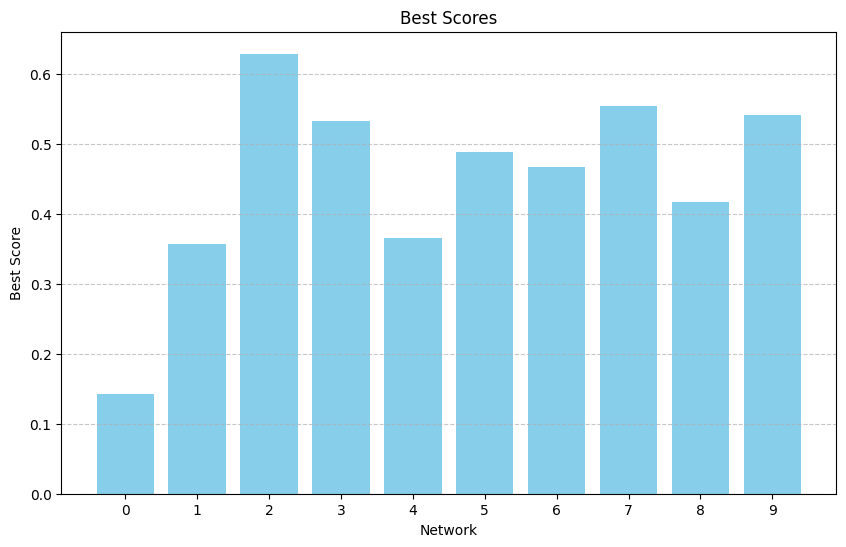

In [ ]:
multi_network_grid_search(csna_p[1000:1100], networks)

X.shape:(4728, 15, 11), y.shape:(4728,)
Epoch 1/64
95/95 [==============================] - 4s 16ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.3200 - val_mse: 0.3200
Epoch 2/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0859 - mse: 0.0859 - val_loss: 0.1946 - val_mse: 0.1946
Epoch 3/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.1054 - val_mse: 0.1054
Epoch 4/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 5/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 6/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0701 - mse: 0.0701 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 7/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 8/64
95/95 [=========================

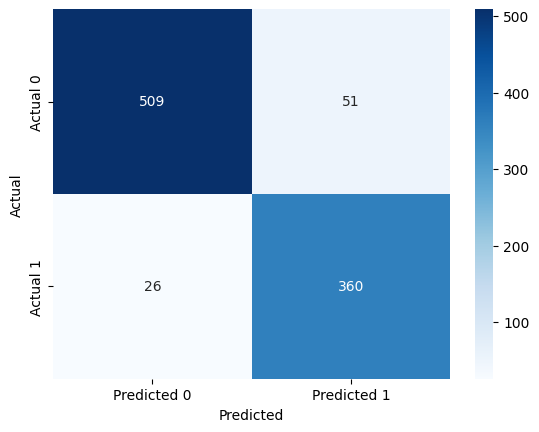

Acurácia: 0.9186046511627907, Precisão: 0.8759124087591241, Recall: 0.9326424870466321, F1: 0.903387703889586


In [ ]:
modelo_csna = create_and_train(csna_p, model=networks[2], batch_size=32, epochs=64)

X.shape:(1171, 15, 11), y.shape:(1171,)
37/37 [==============================] - 0s 7ms/step


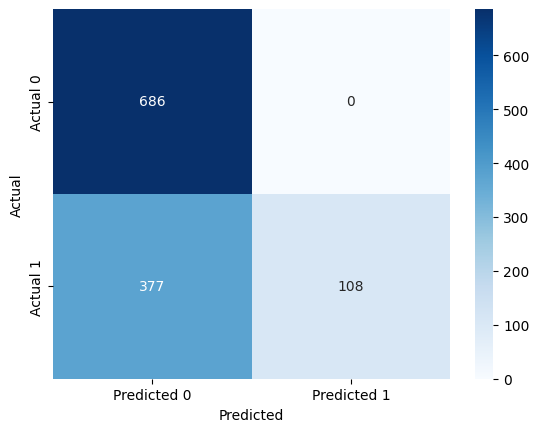

Acurácia: 0.6780529461998293, Precisão: 1.0, Recall: 0.22268041237113403, F1: 0.3642495784148398


In [ ]:
csna_df_t = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/CSNA3.SA/teste.csv")
validate_model(csna_df_t, modelo_csna, 15)

# PETR

In [ ]:
petr_df = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/PETR4.SA/treino.csv")
petr_p = prepare_network_analysis_dataframe(petr_df)

X.shape:(85, 15, 11), y.shape:(85,)
〉〉〉Starting Grid Search Network 0
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ..........batch_size=16, epochs=64;, score=0.486 total time=   4.3s
[CV 2/2] END ..........batch_size=16, epochs=64;, score=0.286 total time=   5.6s
[CV 1/2] END .........batch_size=16, epochs=128;, score=0.486 total time=   2.4s
[CV 2/2] END .........batch_size=16, epochs=128;, score=0.700 total time=   2.9s
[CV 1/2] END ..........batch_size=32, epochs=64;, score=0.486 total time=   1.8s
[CV 2/2] END ..........batch_size=32, epochs=64;, score=0.375 total time=   2.0s
[CV 1/2] END .........batch_size=32, epochs=128;, score=0.486 total time=   3.2s
[CV 2/2] END .........batch_size=32, epochs=128;, score=0.818 total time=   2.7s
Best Parameters: {'batch_size': 32, 'epochs': 128}
Best Score: 0.6523341523341524
〉〉〉Ending Grid Search Newtok 0
〉〉〉Starting Grid Search Network 1
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ....

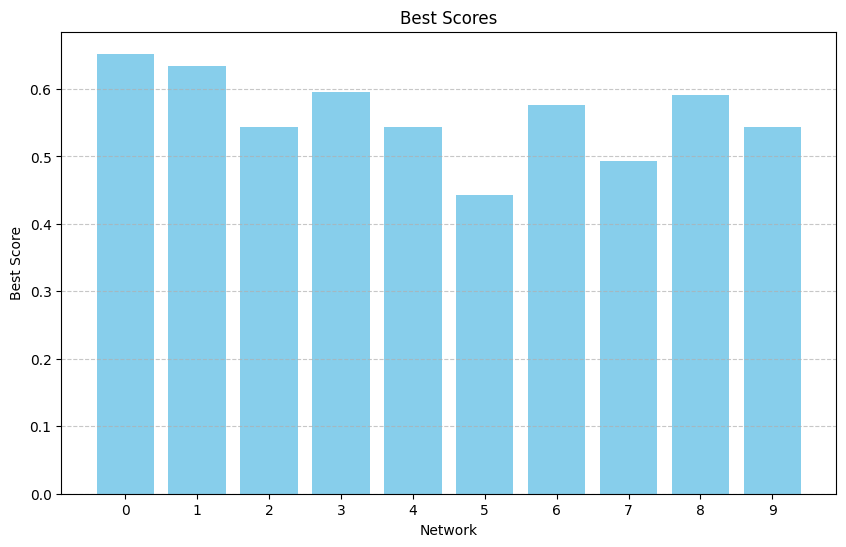

In [ ]:
multi_network_grid_search(petr_p[1000:1100], networks)

X.shape:(4793, 15, 11), y.shape:(4793,)
Epoch 1/128
96/96 [==============================] - 4s 19ms/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.4242 - val_mse: 0.4242
Epoch 2/128
96/96 [==============================] - 1s 8ms/step - loss: 0.0820 - mse: 0.0820 - val_loss: 0.3418 - val_mse: 0.3418
Epoch 3/128
96/96 [==============================] - 1s 8ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.1870 - val_mse: 0.1870
Epoch 4/128
96/96 [==============================] - 1s 6ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 5/128
96/96 [==============================] - 1s 5ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 6/128
96/96 [==============================] - 1s 5ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 7/128
96/96 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 8/128
96/96 [=======================

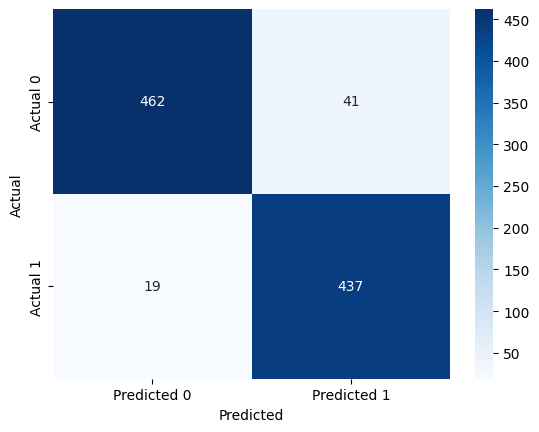

Acurácia: 0.9374348279457768, Precisão: 0.9142259414225942, Recall: 0.9583333333333334, F1: 0.9357601713062098


In [ ]:
modelo_petr = create_and_train(petr_p, model=networks[0], batch_size=32, epochs=128)

X.shape:(1188, 15, 11), y.shape:(1188,)
38/38 [==============================] - 0s 3ms/step


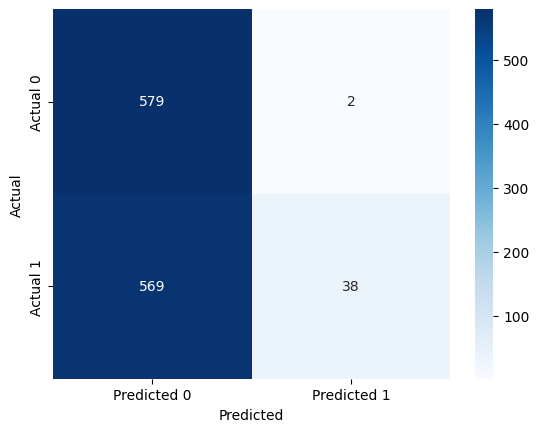

Acurácia: 0.5193602693602694, Precisão: 0.95, Recall: 0.06260296540362438, F1: 0.11746522411128284


In [ ]:
petr_df_t = pd.read_csv("/content/drive/MyDrive/03_Studies/_FIAP/FIAP2024/DeepLearning/FIAP_PI/PETR4.SA/teste.csv")
validate_model(petr_df_t, modelo_petr, 15)

# Estudos prévios
Esta sessão abaixo está mantida apenas para histórico de estudos

## Densa

In [ ]:
simples = Sequential([
    # Input and normalization
    InputLayer(input_shape=(15,11)),   # Camada de Entrada
    BatchNormalization(),           # Normalização

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Flatten(),
    # Output layer
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
])
simples.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
X = bba_p.drop(["Label", "BB_upper_15", "BB_lower_15"], axis=1)
y = bba_p["Label"]

In [ ]:
X, y = make_timesteps_sequences(bba_p, 15)

X.shape:(4720, 15, 11), y.shape:(4720,)


In [ ]:
X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)

In [ ]:
X_train.shape

(3776, 15, 11)

In [ ]:
history = simples.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs
    batch_size=10,  # Size of the batch
    validation_split=0.2  # Split for validation data
)

Epoch 1/10
302/302 [==============================] - 9s 4ms/step - loss: 0.1234 - mse: 0.1234 - val_loss: 0.0929 - val_mse: 0.0929
Epoch 2/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 3/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0845 - mse: 0.0845 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 4/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 5/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0782 - mse: 0.0782 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 6/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0770 - mse: 0.0770 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/10
302/302 [==============================] - 1s 4ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0610 - val_mse: 0.0610
Epoch 8/10
302/302 [==============================] - 1s 4ms/step - loss: 0.

In [ ]:
simples.evaluate(X_test, y_test)

30/30 [==============================] - 0s 3ms/step - loss: 0.0639 - mse: 0.0639


[0.0638834610581398, 0.0638834610581398]

In [ ]:
predictions = simples.predict(X_test)
predictions = (predictions > 0.5).astype(int)

30/30 [==============================] - 0s 2ms/step


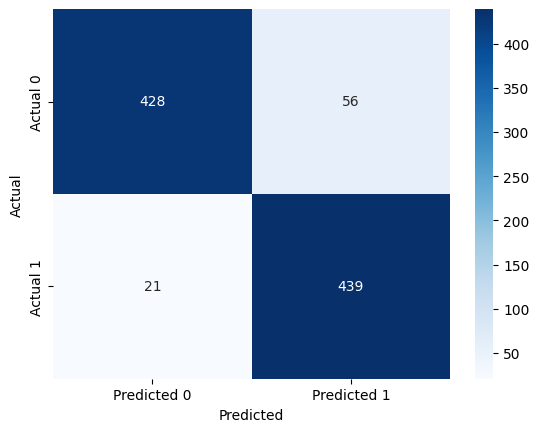

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'Acurácia: {accuracy}, Precisão: {precision}, Revocação: {recall}')

Acurácia: 0.9184322033898306, Precisão: 0.8868686868686869, Revocação: 0.9543478260869566


## Conv 1D

In [ ]:
Conv = Sequential([
    # Input and normalization
    InputLayer(input_shape=(15,11)),   # Camada de Entrada
    BatchNormalization(),           # Normalização
    # Dense layers
    Conv1D(64, kernel_size=5, activation='relu'),
    Dropout(0.5),
    Conv1D(32, kernel_size=3, activation='relu'),
    Dropout(0.5),
    Flatten(),
    # Output layer
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
])
Conv.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mse'])

In [ ]:
X, y = make_timesteps(bba_p, 15)

NameError: name 'make_timesteps' is not defined

In [ ]:
X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)

In [ ]:
history = Conv.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs
    batch_size=10,  # Size of the batch
    validation_split=0.2  # Split for validation data
)

In [ ]:
Conv.evaluate(X_test, y_test)

In [ ]:
predictions = Conv.predict(X_test)
predictions = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'Acurácia: {accuracy}, Precisão: {precision}, Revocação: {recall}')

## LSTM simples

### time_step = 2

In [ ]:
lstm_simples2 = Sequential([
    # Input and normalization
    InputLayer(input_shape=(2,11)),   # Camada de Entrada
    BatchNormalization(),           # Normalização

    LSTM(units=64, activation='relu', input_shape=(2, 11)),

    # Output layer
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
])
lstm_simples2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [ ]:
X, y = make_timesteps_sequences(bba_p, 2)

In [ ]:
X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)

In [ ]:
history = lstm_simples2.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs
    batch_size=10,  # Size of the batch
    validation_split=0.2  # Split for validation data
)

In [ ]:
lstm_simples2.evaluate(X_test, y_test)

In [ ]:
predictions = lstm_simples.predict(X_test)
predictions = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'Acurácia: {accuracy}, Precisão: {precision}, Revocação: {recall}')

### time_step=7

In [ ]:
lstm_simples7 = Sequential([
    # Input and normalization
    InputLayer(input_shape=(7,11)),   # Camada de Entrada
    BatchNormalization(),           # Normalização

    LSTM(units=64, activation='relu', input_shape=(2, 11)),

    # Output layer
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
])
lstm_simples7.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [ ]:
X, y = make_timesteps_sequences(bba_p, 7)

In [ ]:
X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)

In [ ]:
history = lstm_simples7.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs
    batch_size=10,  # Size of the batch
    validation_split=0.2  # Split for validation data
)

In [ ]:
lstm_simples.evaluate(X_test, y_test)

In [ ]:
predictions = lstm_simples.predict(X_test)
predictions = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'Acurácia: {accuracy}, Precisão: {precision}, Revocação: {recall}')

## LSTM Duplo

In [ ]:
lstm_duplo = Sequential([
    InputLayer(input_shape=(2, 11)),  # Correct input shape
    LSTM(units=64, activation='tanh', return_sequences=True),  # Set return_sequences=True when stacking LSTM layers
    BatchNormalization(),  # Batch Normalization after LSTM
    LSTM(units=32, activation='tanh'),  # Additional LSTM layer for complex patterns
    BatchNormalization(),  # Batch Normalization after LSTM
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Additional Dense layer to learn non-linear interactions
    BatchNormalization(),  # Batch Normalization after Dense layer
    Dropout(0.2),  # Additional Dropout for regularization
    Dense(32, activation='relu'),  # Another Dense layer for further interpretation of LSTM outputs
    BatchNormalization(),  # Batch Normalization after Dense layer
    Dense(1, activation='linear')  # Output layer with linear activation for regression
])

lstm_duplo.compile(optimizer='adam',
               loss='mean_squared_error',  # MSE for regression
               metrics=['mse'])  # MSE metric for regression


In [ ]:
X, y = make_timesteps_sequences(bba_p, 2)
X_train, y_train, X_test, y_test = linear_split(X, y, 0.8)

In [ ]:
history = lstm_duplo.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs
    batch_size=10,  # Size of the batch
    validation_split=0.2  # Split for validation data
)

In [ ]:
lstm_duplo.evaluate(X_test, y_test)

In [ ]:
predictions = lstm_duplo.predict(X_test)
predictions = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'Acurácia: {accuracy}, Precisão: {precision}, Revocação: {recall}')